In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
from seglearn.transform import InterpLongToWide, SegmentX, FeatureRep, PadTrunc
from seglearn.pipe import Pype

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import GroupKFold, StratifiedKFold, train_test_split
from sklearn.metrics import confusion_matrix
%matplotlib inline

## Experimenting with Seglearn and RandomForestClassifier

In [28]:
# data = np.load("resampled_nar.npy", allow_pickle=True).item()
data = np.load("cropped_resampled_acc_nar.npy", allow_pickle=True).item()

Resampling was fixed to a frequency of 1ms. Playing with the window size and overlap parameter may help improve accuracy

In [29]:
# mdl

fs = 0.01 # 10 ms
width = int(2.0 / fs) # 2s
overlap = 0.5

# NOTE: removed the interpolation step as resampling was already done
mdl = Pype([('segment', SegmentX(width, overlap)),
            ('ftr', FeatureRep()),
            ('scaler', StandardScaler()),
            ('clf', RandomForestClassifier(n_estimators=500))])

## Using stratified K-folds

In [30]:
# predict exercise class

X = data['X'][:,:,1:]
y = data['exnum']
subject = data['subject']

# gkf = GroupKFold(n_splits=3)
gkf = StratifiedKFold(n_splits=5, shuffle=True, random_state=26)

for i, (train, test) in enumerate(gkf.split(X, y, groups=subject)):
    print("Running on fold: ", i)
    fold = X[train]
    mdl.fit(X[train], y[train])
    acc = mdl.score(X[test], y[test])
    print("Accuracy: ", acc)


Running on fold:  0
Accuracy:  0.8590038314176245
Running on fold:  1
Accuracy:  0.8578874750881497
Running on fold:  2
Accuracy:  0.8616564417177914
Running on fold:  3
Accuracy:  0.8513803680981595
Running on fold:  4
Accuracy:  0.8585455661245781


In [1]:
recon_data = np.load("synthetic_acc_nar_500.npy", allow_pickle=True).item()

NameError: name 'np' is not defined

In [32]:
X_rec = recon_data['X']
y_rec = recon_data['exnum']
acc = mdl.score(X_rec, y_rec)

In [33]:
acc

0.74

## Experimenting with other timeseries classifiers

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torch.optim.lr_scheduler import _LRScheduler

In [6]:
print(torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

True


In [7]:
t = torch.cuda.get_device_properties(0).total_memory
c = torch.cuda.memory_cached(0)
a = torch.cuda.memory_allocated(0)
f = c-a  # free inside cache
print(t)
print(f)

4238737408
0


In [8]:
# DATALOADING
class ExerciseDataset(Dataset):
    """Shoulder exercise dataset"""
    
    def __init__(self, npy_file, length=None, transform=None, sanity_check=None):
        self.dataset = np.load(npy_file, allow_pickle=True).item()
        self.seq_length = length
        self.data = self.process_dataset(length)
        self.data = self.data.astype(np.float)
        self.targets = self.dataset['exnum']
        self.subject = self.dataset['subject']
        
        self.transform = transform
        
        if sanity_check is not None:
            self.data = [self.data[sanity_check]]
            self.targets = [self.targets[sanity_check]]

        assert (len(self.data) == len(self.targets))
        
    def process_dataset(self, length):
        shape = [data.shape[0] for data in self.dataset['X']]
        if length is None:
            average_len = round(sum(shape) / len(shape))
            self.seq_length = average_len
        processed, _, _ = PadTrunc(width=self.seq_length).transform(X=self.dataset['X'])
        return processed
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        
        return torch.from_numpy(self.data[idx]), self.targets[idx]

In [9]:
# dataset = ExerciseDataset("resampled_nar.npy")
dataset = ExerciseDataset("cropped_resampled_acc_nar.npy", length=200)

In [10]:
dataset.seq_length

200

In [11]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
assert train_size + test_size == len(dataset)
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

In [13]:
WORKERS=6
train_loader = DataLoader(train_dataset, batch_size=64, num_workers=WORKERS, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=4, num_workers=WORKERS, shuffle=False, drop_last=True)

In [14]:
class LSTMClassifier(nn.Module):
    """Very simple implementation of LSTM-based time-series classifier."""
    
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.rnn = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(hidden_dim, 100)
#         self.fc2 = nn.Linear(100, output_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.batch_size = None
        self.hidden = None
    
    def forward(self, x):
        h0, c0 = self.init_hidden(x)
        out, (hn, cn) = self.rnn(x, (h0, c0))
        out = self.dropout(out)
#         out = F.relu(self.fc1(out))
#         out = F.softmax(self.fc2(out[:, -1, :]), dim=1)
        out = self.fc2(out[:, -1, :])
        return out
    
    def init_hidden(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)
        return [t.cuda() for t in (h0, c0)]



In [15]:
class CyclicLR(_LRScheduler):
    
    def __init__(self, optimizer, schedule, last_epoch=-1):
        assert callable(schedule)
        self.schedule = schedule
        super().__init__(optimizer, last_epoch)

    def get_lr(self):
        return [self.schedule(self.last_epoch, lr) for lr in self.base_lrs]

In [16]:
def cosine(t_max, eta_min=0):
    
    def scheduler(epoch, base_lr):
        t = epoch % t_max
        return eta_min + (base_lr - eta_min)*(1 + np.cos(np.pi*t/t_max))/2
    
    return scheduler

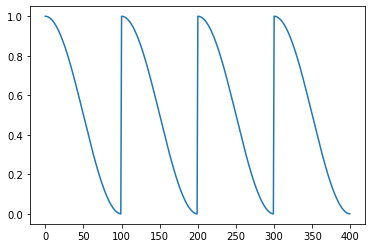

In [17]:
n = 100
sched = cosine(n)
lrs = [sched(t, 1) for t in range(n * 4)]
plt.plot(lrs)

In [18]:
input_dim = 4
# hidden_dim = 256
hidden_dim = 128
layer_dim = 3
output_dim = 9
seq_dim = dataset.seq_length

lr = 0.0005
n_epochs = 100
iterations_per_epoch = len(train_loader)
best_acc = 0
patience, trials = 100, 0

In [19]:
model = LSTMClassifier(input_dim, hidden_dim, layer_dim, output_dim, 0.5)
model = model.cuda()
criterion = nn.CrossEntropyLoss()
criterion = criterion.cuda()
# opt = torch.optim.RMSprop(model.parameters(), lr=lr)
opt = torch.optim.Adam(model.parameters())
# sched = CyclicLR(opt, cosine(t_max=iterations_per_epoch * 2, eta_min=lr/100))

In [20]:
0/0

ZeroDivisionError: division by zero

In [ ]:
print('Start model training')

for epoch in range(1, n_epochs + 1):
    loss = None
    for i, batch in enumerate(train_loader):
#     for i, (x_batch, y_batch) in enumerate(trn_dl):
        model.train()
        x_batch, y_batch = batch
        x_batch = x_batch.float().cuda()
        y_batch = y_batch.long().cuda()
        
        opt.zero_grad()
        out = model(x_batch)
#         print(out)
        loss = criterion(out, y_batch)
#         print(loss.item())
        loss.backward()
        opt.step()
#         sched.step()
    
    model.eval()
    correct, total = 0, 0
    for j, val in enumerate(test_loader):
#     for x_val, y_val in val_dl:
        x_val, y_val = val
        x_val = x_val.float().cuda()
        y_val = y_val.float().cuda()
#         x_val, y_val = [t.cuda() for t in (x_val, y_val)]

        out = model(x_val)
        preds = F.softmax(out, dim=1).argmax(dim=1)
#         preds = torch.argmax(out, dim=1)
        total += y_val.size(0)
        correct += (preds == y_val).sum().item()
    
    acc = correct / total
#     print(acc)

#     if epoch % 5 == 0:
#         print(f'Epoch: {epoch:3d}. Loss: {loss.item():.4f}. Acc.: {acc:2.2%}')

    if epoch % 10 == 0:
        print("Epoch: {}, acc: {}".format(epoch, acc))

    if acc > best_acc:
        trials = 0
        best_acc = acc
        torch.save(model.state_dict(), 'best.pth')
        print(f'Epoch {epoch} best model saved with accuracy: {best_acc:2.2%}')
    else:
        trials += 1
        if trials >= patience:
            print(f'Early stopping on epoch {epoch}')
            break

# Evaluation of best model

In [ ]:
torch.multiprocessing.set_sharing_strategy('file_system')
test_loader = DataLoader(test_dataset, batch_size=4, num_workers=0, shuffle=False, drop_last=True)

In [ ]:
clf = LSTMClassifier(input_dim, hidden_dim, layer_dim, output_dim, 0.5)
clf.load_state_dict(torch.load("best_200_92.pth"))
clf = clf.cuda()
clf.eval()

In [ ]:
# Evaluation
predicted = []
actual = []
total = 0
correct = 0
for j, val in enumerate(test_loader):
    x_val, y_val = val
    actual.append(y_val.numpy())
    
    x_val = x_val.float().cuda()
    y_val = y_val.float().cuda()

    out = clf(x_val)
    preds = F.softmax(out, dim=1).argmax(dim=1)
    predicted.append(preds.cpu().numpy())
    
    total += y_val.size(0)
    correct += (preds == y_val).sum().item()
acc = correct / total
print("Overall accuracY: {}".format(acc))

In [ ]:
ac = [label for array in actual for label in array]

In [ ]:
pre = [label for array in predicted for label in array]

In [ ]:
labels = ['PEN','FLEX', 'SCAP', 'ABD', 'IR', 'ER', 'DIAG', 'ROW', 'SLR']

In [ ]:
# Confusion matrix
conf_matrix = confusion_matrix(ac, pre)
plt.matshow(conf_matrix, cmap='viridis', interpolation='nearest')
plt.colorbar()

In [ ]:
out = clf(test[None])

In [ ]:
preds = F.softmax(out, dim=1).argmax(dim=1)
preds

In [ ]:
predicted

In [ ]:
actual